# Multi-messenger observations of BHNS mergers in the O4 run

## Loading the BHNS population

The BHSN population properties (mass, deformability, redshift ecc.) and EM counterparts (kilonova, GRB prompt and afterglow) are contained in a HDF5 file. We generated $10^6$ binaries with a uniform distribution for the component masses $m_1$ and $m_2$ (between 1 and 2.06 $M_\odot$), for the viewing angle $\theta_v$, (between 0 and $\pi /2$), for the BH spin (between 0 and 1) and with a log-normal distribution for the redshift $z$ (between 0.005 and 4). (The population distributions has to be changed to avoid subsempling problems). For each binary we computed (assuming the SFHo equation of state):"
* the SNR in the LIGO, Virgo and KAGRA detectors with the projected O4 sensitivities;
* the GRB afterglow light curve from 0.1 to 1000 days in the radio, optical and X band;
* the GRB prompt photon flux in the 10-1000 keV (_Fermi_/GBM) and 15-150 keV (_Swif_/BAT) energy band.

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u
import pandas
import corner
import random
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.interpolate import interp2d
from scipy.interpolate import RegularGridInterpolator
from functions import * 
import sys
sys.path.insert(0, './COMPAS')
from spin_class import * 

num = 1000000 #number of binaries
eos = "SFHo" #assumed EoS
table = h5py.File('./population_data/bhns_%i_%s_3deg.hdf5' %(num,eos),'r') #EM and GW population
mns_max = 2.06 #NS maximum mass for the assumed SFHo EoS

DCOtype='BHNS'    
path = './population_data/COMPASCompactOutput_'+ DCOtype +'_A.h5' #Floor's population

### --- Loading Population --- ###
print("Loading intrinsic population")
mbh = table['mbh'][()] #mass of the primary component
mns = table['mns'][()] #mass of the secondary component
lamb_ns = table['lamb_ns'][()] #NS deformability
spin_bh = table['spin_bh'][()] #BH spin
i_tilt = table['i_tilt'][()] #angle between spin and angular momentum 
z = table['z'][()] #redshift
dL = table['dL'][()] #luminosity distance
thv = table['thv'][()] #viewing angle
ra = table['ra'][()]
dec = table['dec'][()]
m_dyn = table['m_dyn'][()] #dynamical ejecta mass
v_dyn = table['v_dyn'][()] #dynamical ejecta velocity
m_disk = table['m_disk'][()] #disk mass
m_out = table['m_out'][()] #ejected mass
final_x = table['final_x'][()] #final spin
E_bkt = table['E_bkt'][()] #brekout energy
E_k_jet = table['E_k_jet'][()] #jet kinetic energy
Ec = table['Ec'][()] #jet core energy

print("Loading GW population")
snr_V_O4 = table['snr_V_O4'][()] #snr Virgo O4
snr_L_O4 = table['snr_L_O4'][()] #snr Ligo L O4
snr_H_O4 = table['snr_H_O4'][()] #snr Ligo H O4
snr_K_O4 = table['snr_K_O4'][()] #snr Kagra O4
snr_O4 = table['snr_net_O4'][()]
Delta_dL_O4 = table['Delta_dL_O4'][()] #luminosity distance error O4
sky_loc_O4 = table['sky_loc_O4'] #delta omega O4 (on axis events are missing, I'll add them ASAP)

print("Loading EM population (kilonova)")
kn_waves = table['kn_waves'][()] #KN bands
t_kn = table['t_kn'][()] #KN time
lc_kn = table['lc_kn'][()] #KN abs mag

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()] #GRB afterglow bands
t_grb = table['t_grb'][()] #GRB afterglow time
lc_grb = table['lc_grb'][()] #GRB afterglow flux

print("Loading EM population (GRB prompt)")
prompt_band = table['prompt_band'][()] #GRB prompt bands
flux_prompt = table['flux_prompt'][()] #GRB prompt photon flux

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)


## Weighing the BHNS population

To have a consistent population it is necessary to weigh it on the basis of the distributions of our interest, in this case we assume Floor's fiducial mass distribution (fixed for every redshift), Bavera+21 for the BH spin prescription, an analytic redshift distribution and for the viewing angle a $\sin\theta_v$ distribution. Each binary will have an associated weight w that will describe its importance in the population. C_mc is the normalization factor for the monte carlo sampling. (As soon as possible I'll provide you with a function to have the mass and the spin distribution as functions of redshift).

In [3]:
spin = calculate_spin_olderCOMPASdata(data_path=path)
spinM1, spinM2  = spin.Bavera21()

#function to compute w and C_mc, the parameters are the mass of the BH, the mass of the NS, 
#the viewing angle, the BH spin, the redshift, the local merger rate density, the minimum delay time, 
#the path to reach Floor's population, the spin of the primary and secondary progenitors.
C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,100,5.e-2,path,spinM1,spinM2) 

/Users/Alberto/Documents/GitHub/O4BHNS/functions.py:144: RuntimeWarning: divide by zero encountered in reciprocal
  y = phi*(tcosmo-tcosmo[i])**-1


## Detectability conditions

We consider two representative sets of detection limits based on the typical depth that can be reached during an EM follow up in response to a GW alert. For each binary we evaluate if it is GW-, KN-, GRB afterglow- and GRB prompt-detectable.

In [4]:
#Shallow limits
print("COUNTERPART SEARCH")

#Detection limits
lim_snr = 12.
lim_kn = np.array([22.,22.,21.])
lim_grb = np.asarray([0.1,5.7e-3,1.5e-6])
lim_prompt_fermi = 4.
lim_prompt_swift = 3.5

#GW
np.random.seed(0)
#dutyO4=GW_duty(0.8,0.8,0.8,0.8,num)
#snr_O4 = np.sqrt(dutyO4[0]*snr_H_O4**2 + dutyO4[1]*snr_L_O4**2 + dutyO4[2]*snr_V_O4**2 + dutyO4[3]*snr_K_O4**2)
gw_det_O4 = snr_O4 >= lim_snr

#KILONOVA
print("Computing KN limiting thresholds")
kn_peak = np.min(lc_kn, axis=2)
kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det[:,j] = kn_peak_APP <= lim_kn[j]
kn_det_all = np.max(kn_det, axis = 1)
kn_det_g = kn_det[:,0]
kn_det_r = kn_det[:,1]
kn_det_J = kn_det[:,2]

#GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det[:,j] = grb_peak[:,j] >= lim_grb[j]
grb_det_all = np.max(grb_det, axis = 1)
grb_det_radio = grb_det[:,0]
grb_det_optic = grb_det[:,1]
grb_det_x = grb_det[:,2]

#GRB PROMPT
print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi = flux_prompt[:,0] >= lim_prompt_fermi

###---Deep Limits
print("CANDIDATE MONITORING")

lim_kn_mon = np.array([28.,28.,28.])
lim_grb_mon = np.asarray([1.e-2,2.3e-5,4.e-7])
lim_prompt_fermi_mon = 1.
lim_prompt_swift_mon = 1.

#KN
print("Computing KN-detectability")
kn_peak = np.min(lc_kn, axis=2)
kn_det_mon = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det_mon[:,j] = kn_peak_APP <= lim_kn_mon[j]
kn_det_all_mon = np.max(kn_det_mon, axis = 1)
kn_det_g_mon = kn_det_mon[:,0]
kn_det_r_mon = kn_det_mon[:,1]
kn_det_J_mon = kn_det_mon[:,2]

#GRB AFTERGLOW
print("Computing GRB afterglow-detectability")
grb_peak = np.max(lc_grb, axis=2)
grb_det_mon = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det_mon[:,j] = grb_peak[:,j] >= lim_grb_mon[j]
grb_det_all_mon = np.max(grb_det_mon, axis = 1)
grb_det_radio_mon = grb_det_mon[:,0]
grb_det_optic_mon = grb_det_mon[:,1]
grb_det_x_mon = grb_det_mon[:,2]

#GRB PROMPT
print("Computing GRB prompt-detectability")
prompt_det_fermi_mon = flux_prompt[:,0] >= lim_prompt_fermi_mon

COUNTERPART SEARCH
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds
CANDIDATE MONITORING
Computing KN-detectability
Computing GRB afterglow-detectability
Computing GRB prompt-detectability


## Detection rates

In [5]:
x = np.sort(z)
s = np.argsort(z)

###--- Counterpart search

#ALL NSNS
cum_tot = C_mc*np.cumsum(w[s])

#GW
cum_gw_O4 = C_mc*np.cumsum(w[s]*gw_det_O4[s])

#KN
cum_gw_kn = C_mc*np.cumsum(w[s]*kn_det_all[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_r = C_mc*np.cumsum(w[s]*kn_det_r[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J = C_mc*np.cumsum(w[s]*kn_det_J[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))  

#GRB AFTERGLOW
cum_gw_grb =  C_mc*np.cumsum(w[s]*grb_det_all[s]*gw_det_O4[s])
cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_O4[s])    
cum_gw_grb_optic =  C_mc*np.cumsum(w[s]*grb_det_optic[s]*gw_det_O4[s])    
cum_gw_grb_x =  C_mc*np.cumsum(w[s]*grb_det_x[s]*gw_det_O4[s])    
    
#GRB PROMPT 
cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_O4[s])
 
###--- Candidate monitoring

#KN
cum_gw_kn_mon = C_mc*np.cumsum(w[s]*kn_det_all_mon[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_mon = C_mc*np.cumsum(w[s]*kn_det_g_mon[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_r_mon = C_mc*np.cumsum(w[s]*kn_det_r_mon[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_J_mon = C_mc*np.cumsum(w[s]*kn_det_J_mon[s]*gw_det_O4[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6)))

#GRB AFTERGLOW 
cum_gw_grb_mon =  C_mc*np.cumsum(w[s]*grb_det_all_mon[s]*gw_det_O4[s])
cum_gw_grb_radio_mon =  C_mc*np.cumsum(w[s]*grb_det_radio_mon[s]*gw_det_O4[s])    
cum_gw_grb_optic_mon =  C_mc*np.cumsum(w[s]*grb_det_optic_mon[s]*gw_det_O4[s])    
cum_gw_grb_x_mon =  C_mc*np.cumsum(w[s]*grb_det_x_mon[s]*gw_det_O4[s]) 

#GRB PROMPT  
cum_gw_fermi_mon = C_mc*np.cumsum(w[s]*prompt_det_fermi_mon[s]*gw_det_O4[s])

Plotting detection rates


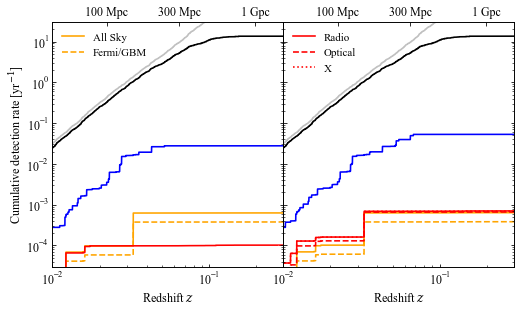

In [6]:
### --- Plotting detection Rates --- ###
print("Plotting detection rates")
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.figsize']=7.5,4.5
plt.rcParams['mathtext.fontset']='dejavuserif'

gs_kw = dict(width_ratios=[1, 1])
fig1,ax = plt.subplots(1,2,gridspec_kw=gs_kw) 

ax[0].loglog(x,cum_gw_O4,c='black',linestyle='-',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_gw_kn,c='blue',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_gw_fermi,label='All Sky',c='orange',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_gw_fermi*0.6,ls="--",label='Fermi/GBM',c='orange',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_gw_grb,c='red',linewidth=1.6,zorder=1)
ax[0].loglog(x,cum_tot,c='silver',linewidth=1.6,zorder=1)
ax[0].legend(loc=2,frameon=False,prop={'size': 11})
ax[0].set_xlabel('Redshift $z$',size=12)
ax[0].set_ylabel(r'Cumulative detection rate [yr$^{-1}$]',size=12)
ax[0].set_ylim((3.e-5,30.))
ax[0].set_xlim((0.01,0.3))
ax[0].set_xticks([0.01,0.1])
ax[0].set_xticklabels(('0.01','0.1'),size=12)
ax[0].minorticks_on()
ax2 = ax[0].twiny()
ax2.set_xlim((0.01,0.3))
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.minorticks_off()
ax2.set_xticks([0.02225,0.0647,0.198])
ax2.set_xticklabels(('100 Mpc','300 Mpc','1 Gpc'),size=12)
ax[0].tick_params(direction='in',which='both',right=True,labelsize=12,zorder=2)
ax2.tick_params(direction='in',which='both',zorder=2)
ax[0].yaxis.labelpad = 0.1
ax[0].set_yscale('log')
ax[0].set_xscale('log')

###--- Candidate monitoring

ax[1].loglog(x,cum_tot,c='silver',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_O4,c='black',linestyle='-',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_kn_mon,c='blue',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_fermi_mon*0.6,c='orange',ls="--",linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_fermi_mon,c='orange',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_grb_radio_mon,label='Radio',c='red',ls='-',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_grb_optic_mon,label='Optical',c='red',ls='--',linewidth=1.6,zorder=1)
ax[1].loglog(x,cum_gw_grb_x_mon,label='X',c='red',ls=':',linewidth=1.6,zorder=1)

ax[1].legend(loc=2,frameon=False,prop={'size': 11})
ax[1].set_xlabel('Redshift $z$',size=12)
ax[1].set_ylim((3.e-5,30.))
ax[1].set_xlim((0.01,0.3))
ax[1].set_xticks([0.01,0.1])
ax[1].set_xticklabels(('0.01','0.1'),size=12)
ax[1].set_yticks([])
ax[1].tick_params(axis = 'y',direction='in',which='both',right=True,labelsize=0,labelcolor="white",zorder=2)
ax[1].tick_params(axis = 'x',direction='in',which='both',labelsize=12)
ax3 = ax[1].twiny()
ax3.set_xlim((0.01,0.3))
ax3.set_xscale('log')
ax3.minorticks_off()
ax3.set_xticks([0.02225,0.0647,0.198])
ax3.set_xticklabels(('100 Mpc','300 Mpc','1 Gpc'),size=12)
fig1.subplots_adjust(wspace=0.,right=0.98)
ax3.tick_params(direction='in',which='both',zorder=2)
ax[1].set_yscale('log')
ax[1].set_xscale('log')

## Kilonova distribution

For the KN we will plot the lightcurves distribution for the O4-detectable binaries in the g and z bands. Then we will add the AT2017gfo data rescaled at the median distance of our population and also the cumulative distribution of the apparent AB magnitude at peak, at 3 and at 5 days after the merger.

/Users/Alberto/miniconda3/envs/astro/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


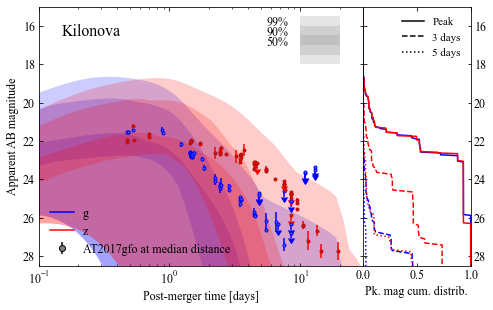

In [7]:
# transform absolute magnitudes to apparent
lc_kn_APP = np.zeros([num,len(kn_waves),len(t_kn)])

for i in range(len(kn_waves)):
    for j in range(len(t_kn)):
        lc_kn_APP[:,i,j] = abs_to_app(lc_kn[:,i,j],dL*1.e6)

mpk_g = np.min(lc_kn_APP[:,0], axis=1)
mpk_z = np.min(lc_kn_APP[:,1], axis=1)
mpk_J = np.min(lc_kn_APP[:,2], axis=1)

mpk_g_3 = np.min(lc_kn_APP[:,0,29:], axis=1)
mpk_z_3 = np.min(lc_kn_APP[:,1,29:], axis=1)
mpk_J_3 = np.min(lc_kn_APP[:,2,29:], axis=1)

mpk_g_5 = np.min(lc_kn_APP[:,0,34:], axis=1)
mpk_z_5 = np.min(lc_kn_APP[:,1,34:], axis=1)
mpk_J_5 = np.min(lc_kn_APP[:,2,34:], axis=1)


# construct confidence regions
perc = [0.01,0.05,0.25,0.5,0.75,0.95,0.99]

conf_curves_g=np.zeros([len(perc),len(t_kn)])
conf_curves_z=np.zeros([len(perc),len(t_kn)])
conf_curves_J=np.zeros([len(perc),len(t_kn)])

gw_det = gw_det_O4
for i in range(len(t_kn)):
    conf_curves_g[:,i]=corner.quantile(lc_kn_APP[:,0,i],perc,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)))
    conf_curves_z[:,i]=corner.quantile(lc_kn_APP[:,1,i],perc,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)))
    conf_curves_J[:,i]=corner.quantile(lc_kn_APP[:,2,i],perc,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)))

# plot confidence curves
kn_bands = ['g','z']
kn_colors = ['blue','red']

left=0.1
bottom=0.14
width=0.6
height=0.8
plt.axes([left,bottom,width,height])

for i,conf in enumerate([conf_curves_g,conf_curves_z]):
    plt.fill_between(t_kn,conf[0],conf[-1],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[1],conf[-2],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)
    plt.fill_between(t_kn,conf[2],conf[-3],edgecolor='None',facecolor=kn_colors[i],alpha=0.2)

if True: # add AT2017gfo for comparison
    ## find median distance
    W = w*gw_det
    s = np.argsort(dL)
    dL_cdf = np.cumsum(W[s])
    dL_cdf/=dL_cdf[-1]
    dL0 = np.sort(dL)
    dL_median = np.interp(0.5,dL_cdf,dL0)
 
    mjd_gw = 57982.5285
    at2017gfo = pandas.read_csv('./AT2017gfo/At2017gfo_photometry.csv')
    dist_mod = 5*np.log10(dL_median/42.)
    zband = at2017gfo['band'].astype(str)=='z'
    gband = at2017gfo['band'].astype(str)=='g'
    Jband = at2017gfo['band'].astype(str)=='J'
    uplims = at2017gfo['upperlimit'].astype(str)=='T'
    at2017gfo['e_magnitude'][uplims]=-0.3
    extinction = {'g':0.4,'z':0.16,'J':0.087} # r: 0.28
    
    plt.errorbar(at2017gfo['time'][gband]-mjd_gw,at2017gfo['magnitude'][gband]+dist_mod-extinction['g'],yerr=at2017gfo['e_magnitude'][gband],markersize=3,markerfacecolor="royalblue",color='blue',ls='None',marker='o',uplims=uplims[gband])
    plt.errorbar(at2017gfo['time'][zband]-mjd_gw,at2017gfo['magnitude'][zband]+dist_mod-extinction['z'],yerr=at2017gfo['e_magnitude'][zband],markersize=3,markeredgecolor='#B11313',color='red',ls='None',marker='o',uplims=uplims[zband])    

plt.errorbar(100,100,yerr=1000,color='black',markerfacecolor="grey",ls='None',label='AT2017gfo at median distance',marker='o')
plt.plot([0.],[0.],color='blue',label='g')
plt.plot([0.],[0.],color='red',label='z')

plt.fill_between([1.e1,2.e1],[18.,18.],[15.5,15.5],color="grey",alpha=0.2,edgecolor=None)
plt.fill_between([1.e1,2.e1],[17.5,17.5],[16.,16.],color="grey",alpha=0.2,edgecolor=None)
plt.fill_between([1.e1,2.e1],[17.,17.],[16.5,16.5],color="grey",alpha=0.2,edgecolor=None)

plt.text(5.5,16.,"99%",size=12)
plt.text(5.5,16.5,"90%",size=12)
plt.text(5.5,17.,"50%",size=12)
plt.text(0.15,16.5,"Kilonova",size=16)

plt.xscale('log')
plt.gca().invert_yaxis()
plt.xlim([1e-1,30.])
plt.ylim([28.5,15.])
plt.xlabel(r'Post-merger time [days]',size=12)
plt.ylabel(r'Apparent AB magnitude',size=12)
plt.tick_params(which='both',direction='in',top=True,right=True,labelsize=12)
plt.legend(loc='lower left',frameon=False,prop={'size': 12})

# construct cumulative peak mag distribution
#np.histogram
s_mpk_g,bins_g,patches = plt.hist(mpk_g,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)
s_mpk_z,bins_z,patches = plt.hist(mpk_z,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)

bincentre_g = np.zeros(len(bins_g)-1)
bincentre_z = np.zeros(len(bins_z)-1)
for j in range(len(bins_g)-1):
    bincentre_g[j] = bins_g[j] + (bins_g[j+1] - bins_g[j]) / 2.
    bincentre_z[j] = bins_z[j] + (bins_z[j+1] - bins_z[j]) / 2.
    
s_mpk_g_3,bins_g_3,patches = plt.hist(mpk_g_3,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)
s_mpk_z_3,bins_z_3,patches = plt.hist(mpk_z_3,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)

bincentre_g_3 = np.zeros(len(bins_g_3)-1)
bincentre_z_3 = np.zeros(len(bins_z_3)-1)
for j in range(len(bins_g_3)-1):
    bincentre_g_3[j] = bins_g_3[j] + (bins_g_3[j+1] - bins_g_3[j]) / 2.
    bincentre_z_3[j] = bins_z_3[j] + (bins_z_3[j+1] - bins_z_3[j]) / 2.
    
s_mpk_g_5,bins_g_5,patches = plt.hist(mpk_g_5,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)
s_mpk_z_5,bins_z_5,patches = plt.hist(mpk_z_5,weights=w*gw_det*((m_dyn>0.)|(m_disk>0.)),cumulative=1, density = 1, bins=1000)

bincentre_g_5 = np.zeros(len(bins_g_5)-1)
bincentre_z_5 = np.zeros(len(bins_z_5)-1)
for j in range(len(bins_g_5)-1):
    bincentre_g_5[j] = bins_g_5[j] + (bins_g_5[j+1] - bins_g_5[j]) / 2.
    bincentre_z_5[j] = bins_z_5[j] + (bins_z_5[j+1] - bins_z_5[j]) / 2.

# plot cumulative distributions
plt.axes([left+width,bottom,1-left-width-0.1,height])
plt.plot(s_mpk_g,bincentre_g,color=kn_colors[0])
plt.plot(s_mpk_z,bincentre_z,color=kn_colors[1])

plt.plot(s_mpk_g_3,bincentre_g_3,color=kn_colors[0],ls="--")
plt.plot(s_mpk_z_3,bincentre_z_3,color=kn_colors[1],ls="--")

plt.plot(s_mpk_g_5,bincentre_g_5,color=kn_colors[0],ls=":")
plt.plot(s_mpk_z_5,bincentre_z_5,color=kn_colors[1],ls=":")

plt.axvline(10,c='black',ls='-',label='Peak')
plt.axvline(10,c='black',ls='--',label='3 days')
plt.axvline(10,c='black',ls=':',label='5 days')

plt.legend(frameon=False,prop={'size': 11})
plt.ylim([28.5,15.])
plt.xlim([0.,1.])
plt.tick_params(which='both',direction='in',labelleft=False,labelright=True,right=True,top=True,labelsize=12)
plt.xlabel('Pk. mag cum. distrib.',size=12)

plt.show()